<a id="top"></a>
# TSM Demo Chunked

<hr>

# Notebook Summary

TSM stands for "Total Suspended Matter" - also called TSS which stands for "Total Suspended Solids". It is the dry-weight of particles suspended (not dissolved) in a body of water. It is a proxy of water quality.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load Data from the Data Cube](#load_data)
    * Mask out clouds and create a median mosaic
    * Show false-color RGB image of the water composite
* [Obtain TSM](#obtain_tsm)
    * Mask out everything but water and calculate TSM
    * Show false-color RGB image of the water composite
    * Show mean TSM
    * Show maximum TSM
    * Show minimum TSM
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Add notebook root to python path
import sys
sys.path.append('../..')

In [2]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import xarray as xr  

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc # The connection to the Open Data Cube.

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [ ]:
# Get available products
products_info = dc.list_products()

# List Landsat 7 products
print("Landsat 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

In [ ]:
# List Landsat 8 products
print("Landsat 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

**Choose products**

In [3]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_ledaps_tanzania"
# platform = "LANDSAT_7"

product = "ls8_lasrc_tanzania"
platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [4]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-11.999154698723961, 0.0)
Longitude Extents: (28.998649001862958, 40.99820216383851)
Time Extents: ['2013-04-12', '2018-01-01']


**Visualize the available area**

In [ ]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [12]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Weija Reservoir, Ghana
# lat = (5.5487, 5.6203) 
# lon = (-0.4028, -0.3326)

# Lake Manyara, Tanzania
# lat = (-3.8180, -3.7610) 
# lon = (35.7402, 35.7976)

# Time Period
# time_extents = ('2015-01-01', '2020-01-01')

# Lake Manyara, Tanzania
lat = (-3.8505, -3.3886) 
lon = (35.7184, 35.9271)

# Time Period
time_extents = ('2015-01-01', '2019-12-31')

from utils.data_cube_utilities.dc_chunker import create_geographic_chunks

# Gather basic information required to process the data in chunks.
metadata = dc.load(latitude = lat,
                   longitude = lon,
                   platform = platform,
                   time = time_extents,
                   product = product,
                   measurements = [])

# Split the region into chunks.
geographic_chunks = create_geographic_chunks(lon, lat, geographic_chunk_size=0.01)

**Visualize the selected area**

In [ ]:
display_map(lat, lon)

## <span id="load_data">Load Data from the Data Cube [&#9652;](#top)</span>

### Mask out clouds and create a median mosaic

In [14]:
rgb_bands = ['nir', 'swir2', 'green']

In [15]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

num_lats, num_lons, num_times = metadata.dims.values()
lat_dim, lon_dim, time_dim = metadata.dims.keys()
time_coords, lat_coords, lon_coords = metadata.coords.values()
composite_shape = (num_lats, num_lons)
composite_dims = (lat_dim, lon_dim)
composite_coords = {lat_dim:lat_coords, lon_dim:lon_coords}

land_and_water_composite = \
    xr.Dataset(coords=composite_coords)
for band in rgb_bands:
    land_and_water_composite[band] = \
        xr.DataArray(np.full(composite_shape, np.nan, dtype=np.int16), 
                     dims=composite_dims, coords=composite_coords)

for chunk_ind, geographic_chunk in enumerate(geographic_chunks):
    lon_chunk, lat_chunk = geographic_chunk.values()
    chunk_selector = dict(latitude=slice(*lat_chunk[::-1]), 
                          longitude=slice(*lon_chunk))
    chunk_dataset = dc.load(latitude = lat_chunk,
                            longitude = lon_chunk,
                            platform = platform,
                            time = time_extents,
                            product = product,
                            measurements = rgb_bands + ['pixel_qa'])
    if len(chunk_dataset) != 0:
        clean_mask = landsat_qa_clean_mask(chunk_dataset, platform=platform)
        chunk_dataset = chunk_dataset.where(clean_mask, -9999)
        chunk_composite = create_median_mosaic(chunk_dataset, clean_mask)
        for band in rgb_bands:
            land_and_water_composite[band].sel(chunk_selector).values[:] = \
                chunk_composite[band].sel(chunk_selector).values
    print("\rProcessed {} out of {} chunks ({:.2%})."
          .format(chunk_ind+1, len(geographic_chunks), 
                  (chunk_ind+1)/len(geographic_chunks)), end='')

Processed 10 out of 10 chunks (100.00%).

### Show false-color RGB image of the land and water composite

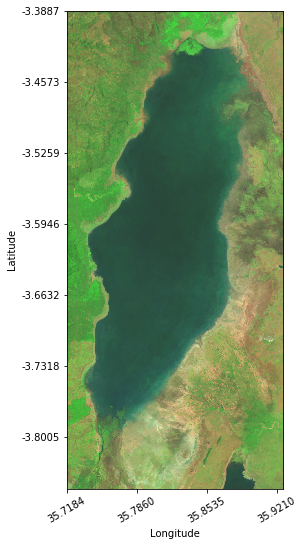

In [45]:
# Show the land and water composite
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.plotter_utils import figure_ratio

# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

fig = plt.figure(figsize=figure_ratio(land_and_water_composite, fixed_width=3))
rgb(land_and_water_composite, bands=['swir2', 'nir', 'green'], 
    min_possible=0, max_possible=5000, fig=fig)
plt.show()

## <span id="obtain_tsm">Obtain TSM [&#9652;](#top)</span>

In [17]:
from utils.data_cube_utilities.dc_water_quality import tsm
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

### Mask out everything but water and calculate TSM

In [18]:
rgb_bands = ['nir', 'swir2', 'green']

In [19]:
water_composite = xr.Dataset(coords=composite_coords)
for band in rgb_bands:
    water_composite[band] = \
        xr.DataArray(np.full(composite_shape, np.nan, dtype=np.int16), 
                     dims=composite_dims, coords=composite_coords)
tsm_min = xr.DataArray(np.full(composite_shape, np.nan, dtype=np.float32), 
                       dims=composite_dims, coords=composite_coords)
tsm_mean = xr.DataArray(np.full(composite_shape, np.nan, dtype=np.float32), 
                       dims=composite_dims, coords=composite_coords)
tsm_max = xr.DataArray(np.full(composite_shape, np.nan, dtype=np.float32), 
                       dims=composite_dims, coords=composite_coords)

for chunk_ind, geographic_chunk in enumerate(geographic_chunks):
    lon_chunk, lat_chunk = geographic_chunk.values()
    chunk_selector = dict(latitude=slice(*lat_chunk[::-1]), \
                          longitude=slice(*lon_chunk))
    chunk_dataset = dc.load(latitude = lat_chunk,
                            longitude = lon_chunk,
                            platform = platform,
                            time = time_extents,
                            product = product,
                            measurements = ['red', 'green', 'blue', 
                                            'nir', 'swir1', 'swir2', 'pixel_qa'])
    if len(chunk_dataset) != 0:
        clean_mask = landsat_qa_clean_mask(chunk_dataset, platform=platform)
        water_mask = wofs_classify(chunk_dataset, clean_mask=clean_mask.values, no_data=0.0)
        water_mask = water_mask.wofs.astype(bool)
        chunk_dataset = chunk_dataset.where(water_mask, -9999)
        chunk_composite = create_median_mosaic(chunk_dataset, water_mask)
        
        for band in rgb_bands:
            water_composite[band].sel(chunk_selector).values[:] = \
                chunk_composite[band].sel(chunk_selector).values
        
        chunk_tsm = tsm(chunk_dataset[['red', 'green']], 
                        clean_mask.values).sel(chunk_selector).tsm
        
        tsm_min.sel(chunk_selector).values[:] = \
            chunk_tsm.sel(chunk_selector).min('time').values
        tsm_mean.sel(chunk_selector).values[:] = \
            chunk_tsm.sel(chunk_selector).mean('time').values
        tsm_max.sel(chunk_selector).values[:] = \
            chunk_tsm.sel(chunk_selector).max('time').values
        
    print("\rProcessed {} out of {} chunks ({:.2%})."
          .format(chunk_ind+1, len(geographic_chunks), 
                  (chunk_ind+1)/len(geographic_chunks)), end=''), chunk_dataset

Processed 10 out of 10 chunks (100.00%).

### Show false-color RGB image of the water composite

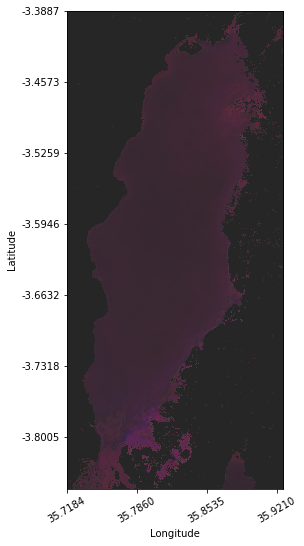

In [46]:
fig = plt.figure(figsize=figure_ratio(water_composite, fixed_width=3))
rgb(water_composite, bands=rgb_bands, fig=fig)
plt.show()

### Show mean TSM

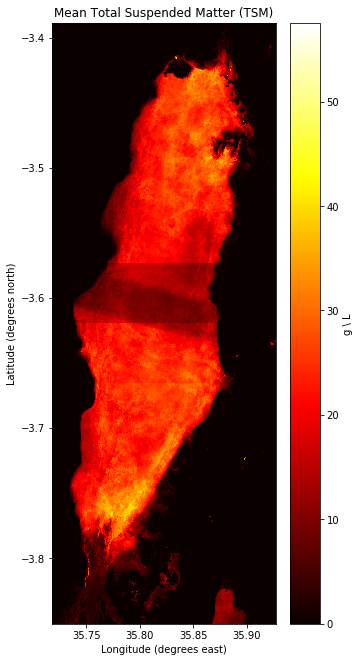

In [52]:
mean_tsm_plot = tsm_mean.plot(figsize=figure_ratio(water_composite, fixed_width=5),cmap = "hot", 
                              vmin=tsm_mean.min(), vmax=tsm_mean.max())
plt.title('Mean Total Suspended Matter (TSM)')
plt.xlabel('Longitude (degrees east)')
plt.ylabel('Latitude (degrees north)')
mean_tsm_plot.colorbar.set_label('g \ L')
plt.show()

### Show maximum TSM

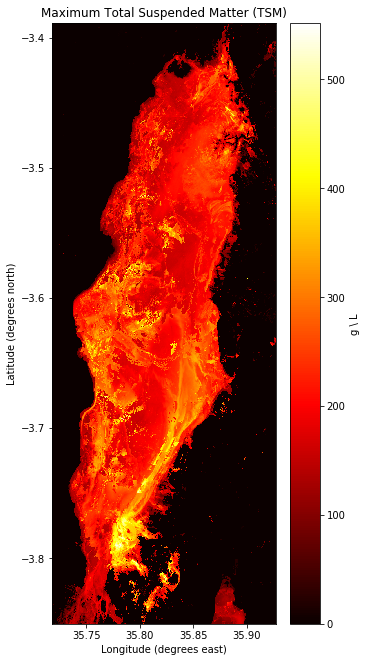

In [54]:
max_tsm_plot = tsm_max.plot(figsize=figure_ratio(water_composite, fixed_width=5),cmap = "hot", 
                            vmin=tsm_max.min(), vmax=tsm_max.max())
plt.title('Maximum Total Suspended Matter (TSM)')
plt.xlabel('Longitude (degrees east)')
plt.ylabel('Latitude (degrees north)')
max_tsm_plot.colorbar.set_label('g \ L')
plt.show()

### Show minimum TSM

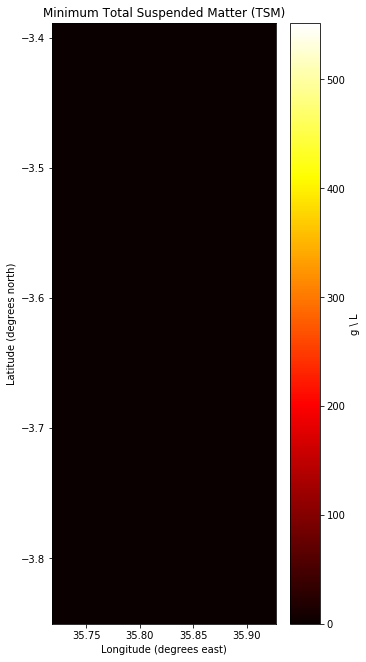

In [55]:
minimum_tsm_plot = tsm_min.plot(figsize=figure_ratio(water_composite, fixed_width=5),cmap = "hot", 
                                vmin=tsm_min.min(), vmax=tsm_max.max())
plt.title('Minimum Total Suspended Matter (TSM)')
plt.xlabel('Longitude (degrees east)')
plt.ylabel('Latitude (degrees north)')
minimum_tsm_plot.colorbar.set_label('g \ L')
plt.show()

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [56]:
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr

# Comment out any undesired lines that export GeoTIFFs. 
# Change the output file paths, or the files will be overwritten for each run.

# Mean TSM
write_geotiff_from_xr('geotiffs/mean_tsm.tif', tsm_mean, ['tsm'])

# Max TSM
write_geotiff_from_xr('geotiffs/max_tsm.tif', tsm_max, ['tsm'])

# Minimum TSM
write_geotiff_from_xr('geotiffs/minimum_tsm.tif', tsm_min, ['tsm'])

In [57]:
!ls -lah geotiffs/*.tif

-rw-rw-r-- 1 localuser localuser 5.1M Oct  3 05:51 geotiffs/manyara_max_tsm.tif
-rw-rw-r-- 1 localuser localuser 5.1M Oct  3 05:51 geotiffs/manyara_mean_tsm.tif
-rw-rw-r-- 1 localuser localuser 5.1M Oct  3 05:51 geotiffs/manyara_minimum_tsm.tif
